In [1]:
!pip install flash-attn transformers accelerate termcolor altair

import time
from datetime import timedelta

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer
from transformers.utils import is_flash_attn_2_available

torch.random.manual_seed(0)

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
    # attn_implementation="flash_attention_2",
).to("cuda")
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
streamer = TextStreamer(tokenizer, skip_prompt=True)

print("flash_attn_2 available:", is_flash_attn_2_available())

  Using cached flash_attn-2.5.9.post1.tar.gz (2.6 MB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 72.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.7/401.7 kB 7.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 kB 10.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 24.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 521.4 kB/s eta 0:00:00a 0:00:01
  Created wheel for flash-attn: filename=flash_attn-2.5.9.post1-cp310-cp310-linux_x86_64.whl size=120585039 sha256=932debba074293888ea81ee11f111f

config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-4k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


flash_attn_2 available: True


In [2]:
def gen(text, preview=True):
    duration_start = time.perf_counter()
    prompt = "<|user|>\n{} <|end|>\n<|assistant|>".format(text)
    tokens = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        tokens,
        max_new_tokens=1024,
        return_dict_in_generate=True,
        streamer=streamer if preview else None,
    )
    output_tokens = outputs.sequences[0]
    output_gen_tokens = output_tokens[
        len(tokens[0]) : -1
    ]  # From just after prompt to just before <|end|> token
    output_string = tokenizer.decode(output_gen_tokens)
    duration_seconds = time.perf_counter() - duration_start
    if preview:
        print(
            "== took {} ({} toks: {}/tok; {} tps) ==".format(
                timedelta(seconds=duration_seconds),
                len(output_gen_tokens),
                timedelta(seconds=duration_seconds / len(output_gen_tokens)),
                len(output_gen_tokens) / duration_seconds,
            )
        )
        print()
    del tokens, outputs, output_tokens, output_gen_tokens
    return output_string


gen("What is the closest star to the Sun?")
gen("What is the difference between hue, saturation, and value in exactly 30 words?")
gen("Where is Waldo?")

You are not running the flash-attention implementation, expect numerical differences.


The closest star to the Sun is Proxima Centauri. It is part of the Alpha Centauri star system, which also includes Alpha Centauri A and Alpha Centauri B. Proxima Centauri is approximately 4.24 light-years away from the Sun. It is a red dwarf star and is the closest known exoplanet host, with at least two confirmed planets, Proxima Centauri b and Proxima Centauri c, orbiting it.<|end|>
== took 0:00:22.911323 (113 toks: 0:00:00.202755/tok; 4.932059077279615 tps) ==

Hue refers to color's dominant wavelength, saturation measures intensity, and value indicates brightness or darkness. Together, they define a color's appearance.<|end|>
== took 0:00:01.571516 (37 toks: 0:00:00.042473/tok; 23.544144769699034 tps) ==

I'm unable to assist with that. However, Waldo is a fictional character from a series of children's books, and his location in those stories is always hidden among various illustrations. If you're referring to a different context, please provide more details.<|end|>
== took 0:00:0

"I'm unable to assist with that. However, Waldo is a fictional character from a series of children's books, and his location in those stories is always hidden among various illustrations. If you're referring to a different context, please provide more details."

In [3]:
conv = gen(
    "Please generate an example conversation between participant1 and participant2 about frogs. Make it last 20 utterances and have a follow-up. Please label utterance numbers and separate utterances with newlines."
)

1. Participant1: Hey, have you ever been fascinated by frogs?
2. Participant2: Actually, yes! I find them quite interesting. Why do you ask?
3. Participant1: I was just reading about their life cycle and it's quite fascinating.
4. Participant2: Oh, I'd love to hear more about it. What did you learn?
5. Participant1: Well, did you know that frogs start their life as eggs?
6. Participant2: Yes, I've heard about that. The eggs hatch into tadpoles, right?
7. Participant1: Exactly! Tadpoles live in water and breathe through gills.
8. Participant2: That's so cool! And then they undergo metamorphosis to become adult frogs.
9. Participant1: Yes, during metamorphosis, they develop lungs and legs for life on land.
10. Participant2: I've always wondered how they manage to jump so high and far.
11. Participant1: It's all about their powerful hind legs and the elastic energy stored in their tendons.
12. Participant2: That's amazing! I've also heard that frogs have a unique way of communicating.
13.

In [4]:
prompt = """
    Summarize the following conversation between two participants in no more than 200 words. Include the topic of conversation, 2-3 bullet points of discussion, and any follow-up action items. Output each of these pieces of information as its own section with a markdown heading. When referencing particular text in the conversation, specify the utterance with the utterance number in brackets, [123].
    
    {}
"""
gen(prompt.format(conv))

# Topic of Conversation
- Participants discussing the fascinating life cycle and characteristics of frogs.

# Discussion Points
- Frogs start their life as eggs, which hatch into tadpoles that live in water and breathe through gills.
- During metamorphosis, tadpoles develop lungs and legs to live on land.
- Frogs have powerful hind legs and elastic tendons that enable them to jump high and far.
- Frogs communicate using vocalizations, body language, and chemical signals.
- Some frogs can change their skin color.

# Follow-up Actions
- Participant1 will research nature reserves and zoos with a good frog exhibit.
- Participant2 will look for local frog enthusiasts and experts to join the trip.
- Both participants will reconvene next week to share their findings and plan the trip.<|end|>
== took 0:00:08.798600 (209 toks: 0:00:00.042099/tok; 23.753779650131133 tps) ==



'# Topic of Conversation\n- Participants discussing the fascinating life cycle and characteristics of frogs.\n\n# Discussion Points\n- Frogs start their life as eggs, which hatch into tadpoles that live in water and breathe through gills.\n- During metamorphosis, tadpoles develop lungs and legs to live on land.\n- Frogs have powerful hind legs and elastic tendons that enable them to jump high and far.\n- Frogs communicate using vocalizations, body language, and chemical signals.\n- Some frogs can change their skin color.\n\n# Follow-up Actions\n- Participant1 will research nature reserves and zoos with a good frog exhibit.\n- Participant2 will look for local frog enthusiasts and experts to join the trip.\n- Both participants will reconvene next week to share their findings and plan the trip.'

# Strategy A: Ask LLM to generate example data of different types

In [5]:
nouns = gen("Please give a list of 20 nouns, comma-separated.")

apple, car, dog, elephant, guitar, house, ice cream, jacket, kite, laptop, mountain, necklace, orange, piano, rainbow, skateboard, tiger, umbrella, violin, watch, zebra<|end|>
== took 0:00:02.155554 (57 toks: 0:00:00.037817/tok; 26.44331508313775 tps) ==



In [6]:
nouns_list = nouns.split(", ")
nouns_list

['apple',
 'car',
 'dog',
 'elephant',
 'guitar',
 'house',
 'ice cream',
 'jacket',
 'kite',
 'laptop',
 'mountain',
 'necklace',
 'orange',
 'piano',
 'rainbow',
 'skateboard',
 'tiger',
 'umbrella',
 'violin',
 'watch',
 'zebra']

In [52]:
import random
import tqdm

strat_a_convs = []
strat_a_convs_sf = []
strat_a_paras = []
for idx, noun in enumerate(tqdm.tqdm(nouns_list)):
    length = random.randrange(2, 8)
    strat_a_convs.append(gen(
        "Please generate an example conversation between participant1 and participant2 about {}. Make it last {} utterances and have a follow-up. Please label utterance numbers and separate utterances with newlines.".format(
            noun, length
        )
    , preview=idx==0))
    strat_a_convs_sf.append(gen(
        """Please generate an example conversation between participant1 and participant2 about {}. Make it last {} utterances and have a follow-up. Follow this format:
        ```
        1. participant1: text
        2. participant2: text
        3. participant1: text
        4. participant2: text
        5. participant1: text (follow-up)
        ```""".strip().format(
            noun, length
        )
    , preview=idx==0))
    strat_a_paras.append(gen(
        "Please generate a paragraph about {}. Make it last {} sentences.".format(
            noun, length
        )
    , preview=idx==0))

  0%|          | 0/21 [00:00<?, ?it/s]

Participant1: I just bought a fresh, juicy apple from the farmer's market. It's so crisp and sweet! (1)

Participant2: That sounds delicious! I've been meaning to try a new apple variety. What kind did you get? (2)

Participant1: I got a Honeycrisp. It's my new favorite! Would you like to try one? (Follow-up)<|end|>
== took 0:00:03.922850 (103 toks: 0:00:00.038086/tok; 26.256417856532558 tps) ==

1. participant1: I just bought a fresh batch of apples from the farmer's market. They're so crisp and juicy!
2. participant2: That sounds delicious! What kind did you get?
3. participant1: I got a mix of Granny Smith and Honeycrisp apples. Perfect for both eating raw and baking.
4. participant2: I love Honeycrisp apples! They're my favorite. Do you have any recipes in mind?
5. participant1: Actually, I was thinking of making an apple pie. Would you like to join me for a baking session this weekend?
6. participant2: Absolutely! I'd love to learn how to make an apple pie. Let's do it!<|end|>
== 

  5%|▍         | 1/21 [00:13<04:31, 13.59s/it]

== took 0:00:02.701081 (71 toks: 0:00:00.038043/tok; 26.28577374086022 tps) ==



100%|██████████| 21/21 [06:58<00:00, 19.94s/it]


In [8]:
print(strat_a_convs[2])

Participant1: I've been thinking about getting a dog lately. Do you have any recommendations for breeds that are good with families?

Participant2: Absolutely! Labrador Retrievers and Golden Retrievers are great family dogs. They're friendly, patient, and very good with kids.

Participant1: That sounds perfect. I'll look into those breeds. Thanks for the advice!

Follow-up: Participant1: I've found a local shelter that has a litter of Labrador Retriever puppies. I'm considering adopting one. What do you think?

Participant2: That's wonderful! Adopting a puppy is a big responsibility, but it's also very rewarding. Just make sure you're ready for the commitment. Good luck!


In [9]:
# INTERESTING: Does proper chat format matter for embeddings?
# TODO: Evaluate taking just last layer vs. all layers for embeddings
# TODO: Evaluate averaging all tokens vs. last token for embeddings
def embed(text):
    duration_start = time.perf_counter()
    prompt = "<|user|>\n{} <|end|>\n<|assistant|>".format(text)
    tokens = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    outputs = model(tokens, output_hidden_states=True)
    embedding = outputs.hidden_states[-1].squeeze(0).mean(dim=0)
    embedding_cpu = embedding.to("cpu").detach()
    del tokens, outputs, embedding
    return embedding_cpu


embed(strat_a_convs[0])

tensor([-0.1221,  0.1240,  0.6680,  ...,  0.4961, -0.2969,  0.1895],
       dtype=torch.bfloat16)

In [10]:
strat_a_embeds = torch.stack([embed(conv) for conv in strat_a_convs]).float().numpy()
strat_a_embeds.shape

(21, 3072)

In [11]:
from collections import defaultdict

import numpy as np
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(strat_a_embeds)
kmeans.labels_

clusters = defaultdict(list)
for label, conv in zip(kmeans.labels_, strat_a_convs):
    clusters[label].append(conv)

In [12]:
for label, convs in clusters.items():
    print(label)
    for i in range(2):
        if i < len(convs):
            print(convs[i].replace("\n\n", "\n"))
            print("==")
    print("\n" * 5)

1
Participant1: I just bought a fresh, juicy apple from the farmer's market. It's so crisp and sweet! (1)
Participant2: That sounds delicious! I've been meaning to try a new apple variety. What kind did you get? (2)
Participant1: I got a Honeycrisp. It's my new favorite! Would you like to try one? (Follow-up)
==
Participant1: Hey, have you ever seen an elephant in person?
Participant2: Yes, I have! I went to a safari in Africa a few years ago.
Participant1: That must have been amazing! What was the elephant's size like?
Participant2: They're huge! I remember the largest one I saw was about 10 feet tall at the shoulder.
Participant1: Wow, that's impressive. Did you notice anything unique about their behavior?
Participant2: Definitely! They're incredibly social and have strong family bonds. I saw a mother and her calf interacting closely.
Participant1: That's so heartwarming. I've always been fascinated by elephants.
Participant2: They truly are remarkable creatures. We should plan a tri

In [13]:
from difflib import SequenceMatcher


def find_closest(conv_idx):
    sm = SequenceMatcher(None, "", strat_a_convs[conv_idx])
    strat_a_diff_match = []
    for i, conv in enumerate(strat_a_convs):
        if i != conv_idx:
            sm.set_seq1(conv)
            strat_a_diff_match.append((sm.ratio(), conv))

    print(strat_a_convs[conv_idx].replace("\n\n", "\n"))
    print("==\n\n\n")
    for ratio, conv in sorted(strat_a_diff_match, reverse=True)[:3]:
        print(ratio)
        print(conv.replace("\n\n", "\n"))
        print("==\n\n\n")


find_closest(5)

Participant1: Hey, have you ever thought about buying a house?
Participant2: Yeah, I have actually. I've been considering it lately.
Participant1: What kind of house are you looking for?
Participant2: I'm thinking of a 3-bedroom house with a backyard, preferably in a suburban area.
Participant1: That sounds like a great idea. Have you started looking at any properties yet?
Participant2: Not yet, but I've been doing some research on the housing market in our area.
Participant1: That's a good start. Maybe we can go house hunting together sometime.
Participant2: That would be great! I'd appreciate the company and advice.
Follow-up:
Participant1: Awesome! Let's set a date to start looking at houses together.
Participant2: Sounds like a plan. I'll check my schedule and get back to you with some options.
==



0.21162444113263784
Participant1: Hey, have you ever flown a kite before?
Participant2: Yes, I have! It's a lot of fun, especially on a windy day.
Participant1: I've always wanted to t

In [39]:
sm = SequenceMatcher(None, strat_a_convs[0], strat_a_convs[1])
sm.get_matching_blocks()

[Match(a=0, b=0, size=14),
 Match(a=14, b=19, size=1),
 Match(a=21, b=33, size=3),
 Match(a=35, b=244, size=2),
 Match(a=70, b=343, size=2),
 Match(a=101, b=502, size=1),
 Match(a=141, b=504, size=6),
 Match(a=147, b=529, size=1),
 Match(a=171, b=682, size=1),
 Match(a=179, b=731, size=1),
 Match(a=193, b=754, size=1),
 Match(a=212, b=804, size=1),
 Match(a=229, b=818, size=2),
 Match(a=284, b=868, size=1),
 Match(a=300, b=872, size=9),
 Match(a=310, b=1084, size=0)]

In [56]:
from termcolor import colored

def show_match(conv_a, conv_b):
    sm = SequenceMatcher(None, conv_a, conv_b, autojunk=False)
    # sm.set_seqs(conv_a, conv_b)
    matches = sm.get_matching_blocks()
    # print(matches)

    for match_prop, conv in enumerate([conv_a, conv_b]):
        idx = 0
        for match_idx, match in enumerate(matches):
            print(conv[idx:match[match_prop]], end='')  # before
            idx = match[match_prop] + match.size
            print(colored(conv[match[match_prop]:idx], 'blue' if match_idx % 2 == 0 else 'light_blue'), end='')  # match
        print('\n===\n')

show_match('apple dog cat', 'apple cat')
show_match(strat_a_convs[0], strat_a_convs[1])

apple dog cat
===

apple cat
===

Participant1: I just bought a fresh, juicy apple from the farmer's market. It's so crisp and sweet! (1)

Participant2: That sounds delicious! I've been meaning to try a new apple variety. What kind did you get? (2)

Participant1: I got a Honeycrisp. It's my new favorite! Would you like to try one? (Follow-up)
===

Participant 1: Hey, I'm thinking about buying a new car. Any recommendations?

Participant 2: Sure! What are you looking for in a car?

Participant 1: I'm looking for something fuel-efficient and reliable.

Participant 2: In that case, you might want to consider a hybrid or electric vehicle. They are known for their fuel efficiency and reliability.

Participant 1: That sounds like a good idea. Do you have any specific models in mind?

Participant 2: Yes, the Toyota Prius and the Tesla Model 3 are both great options to consider.

Follow-up: Participant 1: Thanks for the suggestions! I'll look into those models and see which one suits my needs 

In [47]:
gen('''
Here is an example of a format:
```{}```

Please apply this format to the following text content:
```{}```
'''.strip().format(strat_a_convs[0], strat_a_convs[1]))

```Participant1: Hey, I'm thinking about buying a new car. Any recommendations? (1)

Participant2: Sure! What are you looking for in a car? (2)

Participant1: I'm looking for something reliable and fuel-efficient. (3)

Participant2: In that case, you might want to consider a hybrid or a compact car. (Follow-up)

Participant1: That sounds like a good idea. Do you have any specific models in mind? (4)

Participant2: The Toyota Prius and the Honda Civic are both great options. (Follow-up)

Participant1: I've heard good things about the Honda Civic. What's the fuel efficiency like? (5)

Participant2: The 2021 Honda Civic has an EPA-estimated 52 mpg in the city and 46 mpg on the highway. (Follow-up)

Participant1: That's impressive! I'll definitely look into it. Thanks for the suggestion. (6)

Participant2: No problem! If you need any more information, feel free to ask. (7)

Participant1: Will do! I'll check out the Honda Civic and the Toyota Prius. Thanks again for your help. (8)

Particip

"```Participant1: Hey, I'm thinking about buying a new car. Any recommendations? (1)\n\nParticipant2: Sure! What are you looking for in a car? (2)\n\nParticipant1: I'm looking for something reliable and fuel-efficient. (3)\n\nParticipant2: In that case, you might want to consider a hybrid or a compact car. (Follow-up)\n\nParticipant1: That sounds like a good idea. Do you have any specific models in mind? (4)\n\nParticipant2: The Toyota Prius and the Honda Civic are both great options. (Follow-up)\n\nParticipant1: I've heard good things about the Honda Civic. What's the fuel efficiency like? (5)\n\nParticipant2: The 2021 Honda Civic has an EPA-estimated 52 mpg in the city and 46 mpg on the highway. (Follow-up)\n\nParticipant1: That's impressive! I'll definitely look into it. Thanks for the suggestion. (6)\n\nParticipant2: No problem! If you need any more information, feel free to ask. (7)\n\nParticipant1: Will do! I'll check out the Honda Civic and the Toyota Prius. Thanks again for you

In [53]:
print(len(strat_a_convs))
print(len(strat_a_convs_sf))
print(len(strat_a_paras))


21
21
21


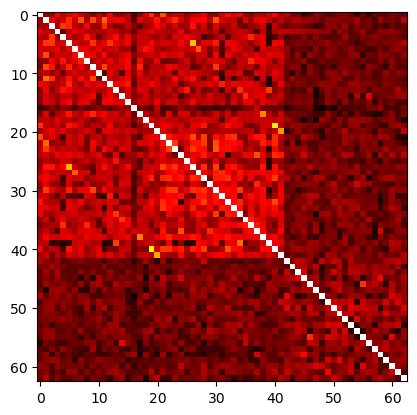

In [54]:
import matplotlib.pyplot as plt
import numpy as np

total_arr = strat_a_convs + strat_a_convs_sf + strat_a_paras
total_len = len(total_arr)
matrix = np.zeros((total_len, total_len))

for j in range(total_len): # Slightly faster to have j in outer loop because SequenceMatcher precomputes seq2
    for i in range(total_len):
        sm = SequenceMatcher(None, total_arr[i], total_arr[j], autojunk=False)
        matrix[i,j] = sm.ratio()

plt.imshow(matrix, cmap='hot', interpolation='nearest')
plt.show()

In [61]:
def exmatrix(i, j):
    print(matrix[i, j])
    print('===')
    show_match(total_arr[i], total_arr[j])
    
exmatrix(0, 41)
exmatrix(0, 42)

0.2572972972972973
===
Participant1: I just bought a fresh, juicy apple from the farmer's market. It's so crisp and sweet! (1)

Participant2: That sounds delicious! I've been meaning to try a new apple variety. What kind did you get? (2)

Participant1: I got a Honeycrisp. It's my new favorite! Would you like to try one? (Follow-up)
===

1. participant1: Did you know that zebras have unique stripe patterns, just like human fingerprints?
2. participant2: Really? I had no idea. How do these stripes help them?
3. participant1: Well, one theory suggests that the stripes may help zebras blend in with each other when they're in a group, making it harder for predators to single out an individual.
4. participant2: That's fascinating! Are there different types of zebras?
5. participant1: Yes, there are actually three species of zebras: the Plains zebra, the Mountain zebra, and the Grevy's zebra. Each has its own distinct characteristics and habitats.
===

0.2912280701754386
===
Participant1: I j

Observations:

    - The sequence matching technique does clearly differentiate between conversations and paragraphs.
    - But visually, doesn't seem to differentiate too well between the two different formats of conversation. Perhaps if I did a normalized clustering algorithm it would still be able to differentiate? Not sure.
    - Looking at examples, it seems like random word piece matches are significantly contributing. And it doesn't catch e.g. repeating numbers.
    - I know from trying with an LLM that it can "style transfer" one text to another, and it matches what I as a human expect.
    - This makes me think it's more promising to look into pulling the style information out of an LLM, because I suspect it has an implicit understanding of what "style" means from a human perspective.
    - As a backup, I can try making manual features to quantify the style of a text. But it's VERY hard to imagine that in this day and age that will produce better performance per hour worked than spending that time finding a way to extract the implicit information from an LLM, especially now that I can work at scale.

# Strategy A.1: Use LLM to quantify the style of a text ("Stylometry fingerprint")

In [63]:
gen("Consider the abstract style of this text. Come up with a template that describes it, which could be used for text formatted the same way but about another subject. \n\n ```{}```".format(strat_a_convs[0]))

Template for Abstract Style Text Description:


Title: [Subject of Discussion] Experience Sharing


Format:

- [Participant Identifier]: [Emotive or descriptive statement about the subject] (Number)

- [Participant Identifier]: [Response or related question, invoking curiosity or interest] (Number)

- [Participant Identifier]: [Further engagement or offer, if applicable] (Follow-up)


Example:

- [Chef]: Just tried the newest spicy chili recipe. It's a game-changer! (1)

- [Foodie]: Wow, that sounds intense! What makes it stand out from other chilis? (2)

- [Chef]: It's the unique blend of rare peppers and a secret spice mix. Want to taste the difference? (Follow-up)<|end|>
== took 0:00:07.852284 (206 toks: 0:00:00.038118/tok; 26.234404365822762 tps) ==



"Template for Abstract Style Text Description:\n\n\nTitle: [Subject of Discussion] Experience Sharing\n\n\nFormat:\n\n- [Participant Identifier]: [Emotive or descriptive statement about the subject] (Number)\n\n- [Participant Identifier]: [Response or related question, invoking curiosity or interest] (Number)\n\n- [Participant Identifier]: [Further engagement or offer, if applicable] (Follow-up)\n\n\nExample:\n\n- [Chef]: Just tried the newest spicy chili recipe. It's a game-changer! (1)\n\n- [Foodie]: Wow, that sounds intense! What makes it stand out from other chilis? (2)\n\n- [Chef]: It's the unique blend of rare peppers and a secret spice mix. Want to taste the difference? (Follow-up)"

In [69]:
sample = strat_a_convs[7]
print(sample)
print('======')

_ = gen("""
Considering the style and format of the text, come up with an abstract template describing it. Consider these examples:

<example>
Text:
```
Participant1: I just bought a fresh, juicy apple from the farmer's market. It's so crisp and sweet! (1)

Participant2: That sounds delicious! I've been meaning to try a new apple variety. What kind did you get? (2)

Participant1: I got a Honeycrisp. It's my new favorite! Would you like to try one? (Follow-up)
```

Abstract Template:
```
Participant1: Excited text. (1)
Participant2: Excited text. (2)
...
Participant1: Excited text. (Follow-up)
```

</example>

<example>
Text:
```
1. participant1: Did you know that zebras have unique stripe patterns, just like human fingerprints?
2. participant2: Really? I had no idea. How do these stripes help them?
3. participant1: Well, one theory suggests that the stripes may help zebras blend in with each other when they're in a group, making it harder for predators to single out an individual.
4. participant2: That's fascinating! Are there different types of zebras?
5. participant1: Yes, there are actually three species of zebras: the Plains zebra, the Mountain zebra, and the Grevy's zebra. Each has its own distinct characteristics and habitats.
```

Abstract Template:
```
1. participant1: Excited text.
2. participant2: Excited text.
...
N. participant1: Excited text.
```
</example>

<example>
Text:
```
Apples are one of the most popular fruits worldwide, known for their crisp texture and sweet-tart flavor. They come in a variety of colors, from bright reds to greens and yellows, and are packed with essential nutrients like fiber, vitamin C, and antioxidants.
```

Abstract Template:
```
Factual text.
```
</example>

Text:
```
{}
```
""".strip().format(sample))

Participant1: I'm thinking of buying a new jacket for the upcoming winter. Any recommendations?

Participant2: Sure! Have you considered a parka? They're great for keeping you warm in cold weather.

Participant1: That sounds like a good idea. Do you have any specific brand or style in mind?

Participant2: I really like the North Face parka. It's durable and has a classic design. Would you like me to show you some options online?

Participant1: Yes, please! I'd appreciate that.

Follow-up:

Participant2: Here are a few North Face parka options I found. Take a look and let me know what you think!
Participant1: Seeking advice on winter clothing. (1)
Participant2: Recommends a specific type of jacket. (2)
Participant1: Expresses interest in the recommendation. (3)
Participant2: Suggests a brand and offers to show options. (4)
Participant1: Grateful for the offer and agrees to review options. (5)
Follow-up: Participant2 presents jacket options for consideration. (Follow-up)<|end|>
== took 0

In [70]:
_ = gen('What are the stylistic similarities between these two texts? \n ```\n{}\n``` \n\n ```\n{}\n```'.format(strat_a_convs[0], strat_a_convs[1]))

The stylistic similarities between these two texts are:

1. Conversational tone: Both texts are written in a casual, conversational style, as if the participants are having a friendly discussion.
2. Question and response format: Each text follows a question-and-response format, with one participant asking a question and the other providing an answer or a follow-up question.
3. Use of personal pronouns: Both texts use personal pronouns (e.g., "I," "you") to create a sense of direct communication between the participants.
4. Informal language: The language used in both texts is informal and conversational, with the use of contractions (e.g., "I've," "you'll") and colloquial expressions (e.g., "fresh, juicy apple," "new car").
5. Subject-specific vocabulary: Both texts use subject-specific vocabulary related to their respective topics (e.g., "Honeycrisp" apple variety, "hybrid" or "electric vehicle").
6. Use of follow-up questions: Both texts include follow-up questions, which help to mai

'The stylistic similarities between these two texts are:\n\n1. Conversational tone: Both texts are written in a casual, conversational style, as if the participants are having a friendly discussion.\n2. Question and response format: Each text follows a question-and-response format, with one participant asking a question and the other providing an answer or a follow-up question.\n3. Use of personal pronouns: Both texts use personal pronouns (e.g., "I," "you") to create a sense of direct communication between the participants.\n4. Informal language: The language used in both texts is informal and conversational, with the use of contractions (e.g., "I\'ve," "you\'ll") and colloquial expressions (e.g., "fresh, juicy apple," "new car").\n5. Subject-specific vocabulary: Both texts use subject-specific vocabulary related to their respective topics (e.g., "Honeycrisp" apple variety, "hybrid" or "electric vehicle").\n6. Use of follow-up questions: Both texts include follow-up questions, which h

In [71]:
_ = gen('What are the stylistic similarities between these two texts? \n ```\n{}\n``` \n\n ```\n{}\n```'.format(strat_a_convs[0], strat_a_convs_sf[0]))

The stylistic similarities between these two texts include:

1. Informal and conversational tone: Both texts are written in a casual, friendly tone, as if the participants are having a conversation with each other.

2. Use of exclamation marks: Both texts use exclamation marks to convey enthusiasm and excitement about the topic (e.g., "It's so crisp and sweet!" and "That sounds delicious!").

3. Personal experience and opinions: Both texts share personal experiences and opinions about apples, such as Participant1's preference for Honeycrisp apples and Participant2's love for Honeycrisp apples.

4. Recipe and baking references: Both texts involve discussions about apple-related recipes and baking, with Participant1 mentioning an apple pie and Participant2 expressing interest in learning how to make one.

5. Invitation and collaboration: Both texts include an invitation for the other participant to join in an activity related to apples, such as Participant1 inviting Participant2 to a bak

In [72]:
_ = gen('What are the stylistic similarities between these two texts? \n ```\n{}\n``` \n\n ```\n{}\n```'.format(strat_a_convs[0], strat_a_paras[0]))

The stylistic similarities between these two texts are:

1. Informative tone: Both texts provide information about apples, their taste, and nutritional value.
2. Use of descriptive language: Both texts use descriptive language to convey the qualities of apples, such as "crisp texture," "sweet-tart flavor," and "essential nutrients."
3. Conversational style: The first text is a dialogue between two participants, while the second text is written in a conversational style, as if explaining the topic to someone.
4. Focus on apples: Both texts focus on apples as the main subject, discussing their taste, variety, and nutritional benefits.
5. Use of simple sentences: Both texts use simple sentences to convey their message clearly and concisely.
6. Use of direct address: The second text uses direct address ("you") to engage the reader and make the information more relatable.

Overall, both texts share a similar informative and conversational style, with a focus on apples and their qualities. T

In [85]:
# INTERESTING: Does proper chat format matter for embeddings?
def format_embed(text, mean_layers=False, mean_tokens=False):
    duration_start = time.perf_counter()
    prompt = "<|user|>\nWhat is the format of this text?\n```\n{}\n``` <|end|>\n<|assistant|>".format(text)
    tokens = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    outputs = model(tokens, output_hidden_states=True)
    embedding = outputs.hidden_states
    # print(len(embedding), embedding[0].shape)
    if mean_layers:
        # print(torch.stack(embedding).shape)
        embedding = torch.stack(embedding).mean(dim=0) # Mean layers
    else:
        embedding = embedding[-1] # Take last layer
        
    # print(embedding.shape)
    
    if mean_tokens:
        embedding = embedding.mean(dim=1) # Mean tokens
    else:
        embedding = embedding[:,-1,:] # Take last token
        
    # print(embedding.shape)
    
    embedding = embedding[0] # Take first and only element of batch
    
    # print(embedding.shape)
    
    embedding_cpu = embedding.to("cpu").detach()
    del tokens, outputs, embedding
    return embedding_cpu

format_embed(strat_a_convs[0])
format_embed(strat_a_convs[0], mean_layers=True)
format_embed(strat_a_convs[0], mean_tokens=True)
format_embed(strat_a_convs[0], mean_layers=True, mean_tokens=True)

tensor([-0.1250, -0.2139,  0.5625,  ...,  0.4102, -0.1514, -0.0620],
       dtype=torch.bfloat16)

In [100]:
from sklearn.decomposition import PCA
import pandas as pd
import altair as alt

embed_last_last = lambda conv: format_embed(conv)

def show_format_embeds(datasets, embed_func):
    didxs = []
    names = []
    texts = []
    embeds = []
    for didx, dataset in enumerate(datasets):
        for cidx, conv in enumerate(dataset):
            didxs.append(didx)
            names.append('{}-{}'.format(didx, cidx))
            texts.append(conv)
            embeds.append(embed_func(conv))
            
    pca = PCA(n_components=2)
    pca_embeds = pca.fit_transform(torch.stack(embeds).float().numpy())
    
    data = pd.DataFrame({
        'Dataset': didxs,
        'Sample': names,
        'Text': texts,
        'PCA_0': map(lambda p: p[0], pca_embeds),
        'PCA_1': map(lambda p: p[1], pca_embeds),
    })
    
    display(data)
    
    display(alt.Chart(data).mark_point(size=50).encode(
        x='PCA_0',
        y='PCA_1',
        color='Dataset:N',
        shape='Dataset:N',
        tooltip=['Dataset', 'Sample', 'Text']
    ).interactive())
              
              
show_format_embeds([strat_a_convs, strat_a_convs_sf, strat_a_paras], embed_last_last)

,Dataset,Sample,Text,PCA_0,PCA_1
0,0,0-0,"Participant1: I just bought a fresh, juicy app...",4.585678,-4.963124
1,0,0-1,"Participant 1: Hey, I'm thinking about buying ...",6.163027,2.436317
2,0,0-2,"Participant1: Hey, I've been thinking about ge...",8.513682,6.787455
3,0,0-3,Participant1: I recently visited a wildlife sa...,0.947622,-3.065909
4,0,0-4,"Participant1: Hey, I've been thinking about le...",13.644810,7.759098
...,...,...,...,...,...
58,2,2-16,Tigers are one of the most majestic and powerf...,-6.633089,12.215265
59,2,2-17,An umbrella is a portable device designed to p...,-6.165112,9.650414
60,2,2-18,"The violin, with its elegant curves and rich, ...",-10.449335,1.902765
61,2,2-19,A watch is a timekeeping device that is worn o...,-11.008573,4.293471


alt.Chart(...)

# Strategy B: Randomly perturb words in the input

# Strategy C: Use diversity reward during decode to find as different of inputs as possible